In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from datetime import datetime, timedelta

# Database credentials
db_username = 'admin'
db_password = 'UBCParking2024'
db_server = 'testdb.cdq6s8s6klpd.ca-central-1.rds.amazonaws.com'
db_name = 'Parking'

# SQLAlchemy connection string
connection_string = f'mssql+pyodbc://{db_username}:{db_password}@{db_server}/{db_name}?driver=ODBC+Driver+17+for+SQL+Server'

# Create the SQLAlchemy engine
engine = create_engine(connection_string)

# List of tables to query with their new names
tables = {
    'dbo.NorthParkade_Occupancy': 'North',
    'dbo.WestParkade_Occupancy': 'West',
    'dbo.RoseGardenParkade_Occupancy': 'Rose',
    'dbo.HealthSciencesParkade_Occupancy': 'Health Sciences',
    'dbo.FraserParkade_Occupancy': 'Fraser',
    'dbo.ThunderbirdParkade_Occupancy': 'Thunderbird',
    'dbo.UnivWstBlvdParkade_Occupancy': 'University Lot Blvd'
}

# Calculate timestamp range for the past week
end_date = datetime.now()
start_date = end_date - timedelta(days=7)



# Convert dates to Unix timestamps
start_timestamp_unix = int(start_date.timestamp())
end_timestamp_unix = int(end_date.timestamp())

# Initialize DataFrame to hold results
all_data = pd.DataFrame()

# Query each table and concatenate results
with engine.connect() as connection:
    for table, new_name in tables.items():
        print(f"Querying table: {table}")
        
        query = f"""
        SELECT Vehicles, TimestampUnix
        FROM {table}
        WHERE TimestampUnix BETWEEN {start_timestamp_unix} AND {end_timestamp_unix}
        """
        df = pd.read_sql(query, connection)

        # Convert TimestampUnix to datetime
        df['Timestamp'] = pd.to_datetime(df['TimestampUnix'], unit='s')
        df.set_index('Timestamp', inplace=True)

        # Drop the TimestampUnix column
        df.drop(columns='TimestampUnix', inplace=True)

        # Rename the 'Vehicles' column to the parkade name
        df.rename(columns={'Vehicles': new_name}, inplace=True)
        
        # Align with the main DataFrame
        all_data = pd.concat([all_data, df], axis=1)

# Ensure data is aggregated by hour
all_data = all_data.resample('H').last()  # Get the last record within each hour
# Drop duplicate columns in case of overlapping timestamps
all_data = all_data.groupby(all_data.index).first()

# Reset index to make Timestamp a column again
all_data.reset_index(inplace=True)

# Save to CSV (optional)


Querying table: dbo.NorthParkade_Occupancy
Querying table: dbo.WestParkade_Occupancy
Querying table: dbo.RoseGardenParkade_Occupancy
Querying table: dbo.HealthSciencesParkade_Occupancy
Querying table: dbo.FraserParkade_Occupancy
Querying table: dbo.ThunderbirdParkade_Occupancy
Querying table: dbo.UnivWstBlvdParkade_Occupancy


C:\Users\ginap\AppData\Local\Temp\ipykernel_14692\934091101.py:68: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  all_data = all_data.resample('H').last()  # Get the last record within each hour


In [16]:
all_data.tail()

,Timestamp,North,West,Rose,Health Sciences,Fraser,Thunderbird,University Lot Blvd
63,2024-08-01 16:00:00,380.0,327.0,135.0,601,136.0,428.0,44
64,2024-08-01 17:00:00,408.0,356.0,156.0,653,148.0,465.0,51
65,2024-08-01 18:00:00,420.0,379.0,165.0,679,156.0,478.0,75
66,2024-08-01 19:00:00,431.0,381.0,185.0,672,161.0,468.0,61
67,2024-08-01 20:00:00,434.0,385.0,181.0,669,163.0,467.0,56


Data retrieval complete. Saved to 'hourly_parkade_data.csv'.


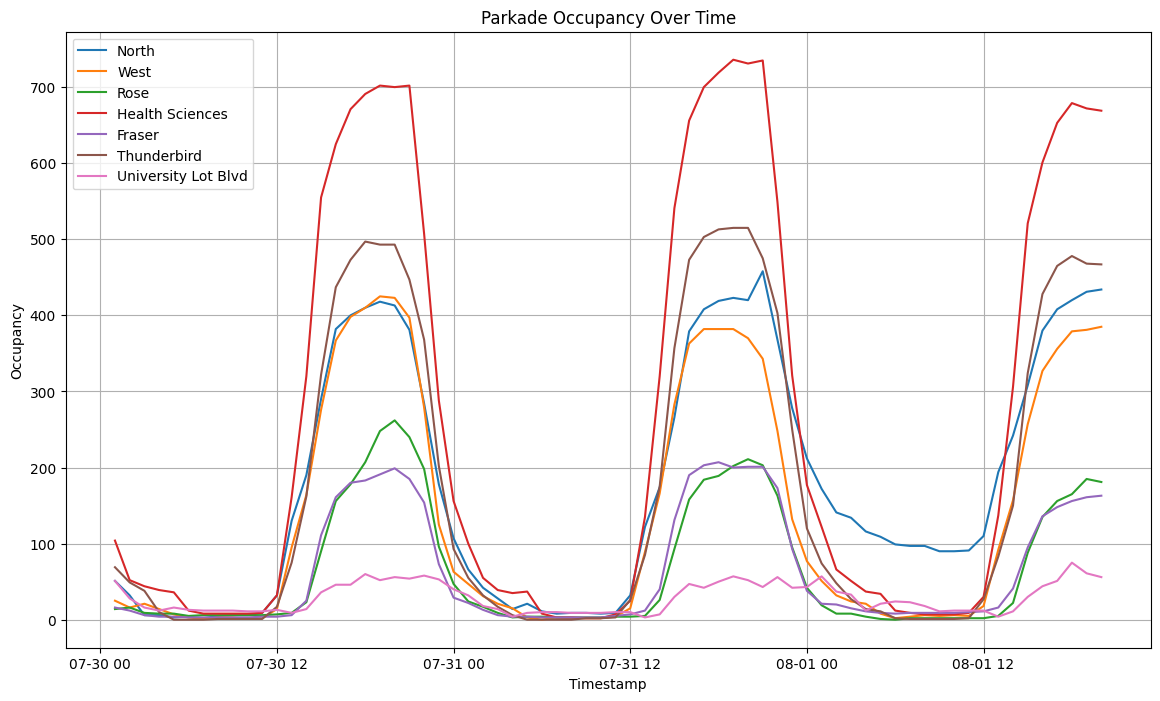

In [17]:
all_data.to_csv('hourly_parkade_data.csv', index=False)

print("Data retrieval complete. Saved to 'hourly_parkade_data.csv'.")

# Plotting the data
plt.figure(figsize=(14, 8))

for column in all_data.columns[1:]:  # Skip the 'Timestamp' column
    plt.plot(all_data['Timestamp'], all_data[column], label=column)

plt.title('Parkade Occupancy Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Occupancy')
plt.legend()
plt.grid(True)

# Save the plot to a file
plt.savefig('parkade_occupancy_plot.png')

# Show the plot
plt.show()

In [18]:
print(start_date)
print(end_date)

2024-07-29 20:34:28.086376
2024-08-05 20:34:28.086376
